In [1]:
using Pkg
Pkg.activate("..")
using Colors, Compose, DrWatson, DataFrames, GraphPlot, HypothesisTests, LightGraphs, Plots, SimpleWeightedGraphs, StatsPlots
import Cairo, Fontconfig
include(srcdir("load.jl"))
ENV["GKS_WSTYPE"] = "svg"
const outdir = projectdir("tmp", "plots", "graphs")
mkpath(outdir)

Activating environment at `~/dglmoore/yuji/Project.toml`


┌ Info: Precompiling HypothesisTests [09f84164-cd44-5f33-b23f-e6b0d136a0d5]
└ @ Base loading.jl:1273
┌ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1273


"/home/ec2-user/dglmoore/yuji/tmp/plots/graphs"

In [2]:
function symmetrize(A)
    for i in 1:size(A,1), j in i+1:size(A,2)
        if A[i,j] != A[j,i]
            if A[i,j] ≈ zero(A[i,j])
                A[i,j] = A[j,i]
            elseif A[j,i] ≈ zero(A[j,i])
                A[j,i] = A[i,j]
            else
                A[i,j] = A[j,i] = min(A[i,j], A[j,i])
            end
        end
    end
    A
end

function issymmetric(A)
    for i in 1:size(A,1), j in i+1:size(A,2)
        if A[i,j] != A[j,i]
            return false
        end
    end
    true
end

issymmetric (generic function with 1 method)

In [3]:
function load_mi_result(; drug="K-gluconate", trial=1, phase="before", gh=30, gw=30, lag=0, nperms=100000)
    d = wload(datadir("info", "mi", savename((@dict drug trial phase gh gw lag nperms), "bson")))
    d[:mi] = linearize(d[:mi])
    if !issymmetric(d[:mi])
        symmetrize(d[:mi])
    end
    d
end

load_mi_result (generic function with 1 method)

In [4]:
function load_te_result(; drug="K-gluconate", trial=1, phase="before", gh=30, gw=30, k=1, nperms=100000)
    d = wload(datadir("info", "te", savename((@dict drug trial phase gh gw k nperms), "bson")))
    d[:te] = linearize(d[:te])
    net = d[:te]
    net = net - transpose(net)
    net[net .< zero(eltype(net))] .= zero(eltype(net))
    d[:nette] = net
    d
end

load_te_result (generic function with 1 method)

In [5]:
before = load_mi_result(drug="K-gluconate", phase="before")
after = load_mi_result(drug="K-gluconate", phase="after")

Gᵦ = SimpleWeightedGraph(before[:mi])
Gₐ = SimpleWeightedGraph(after[:mi])

{900, 11387} undirected simple Int64 graph with Float64 weights

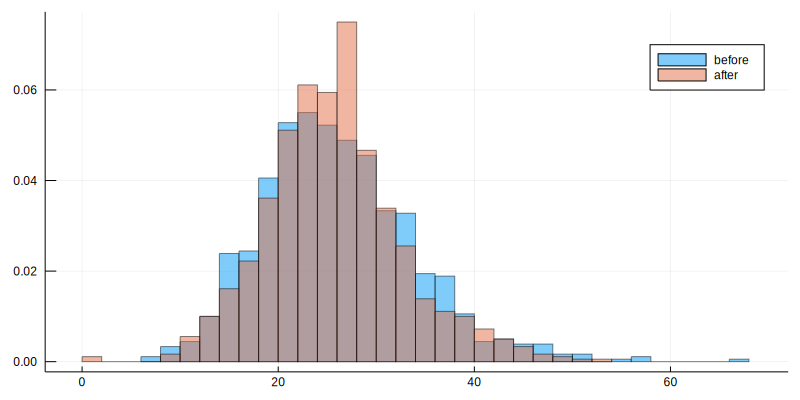

In [6]:
histogram(hcat(degree(Gᵦ), degree(Gₐ)), labels=["before" "after"], α=0.5, size=(800,400), normalize=true)

In [7]:
ApproximateTwoSampleKSTest(indegree(Gᵦ), indegree(Gₐ))

┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests /home/ec2-user/.julia/packages/HypothesisTests/M3Ysg/src/kolmogorov_smirnov.jl:167


Approximate two sample Kolmogorov-Smirnov test
----------------------------------------------
Population details:
    parameter of interest:   Supremum of CDF differences
    value under h_0:         0.0
    point estimate:          0.08888888888888889

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           0.0016

Details:
    number of observations:   [900,900]
    KS-statistic:              1.885618083164127


In [48]:
before = load_te_result(drug="K-gluconate:Nifedipine", phase="before", k=3)
after = load_te_result(drug="K-gluconate:Nifedipine", phase="after", k=3)

Gᵦ = SimpleWeightedDiGraph(before[:te])
Gₐ = SimpleWeightedDiGraph(after[:te])

Gnetᵦ = SimpleWeightedDiGraph(before[:nette])
Gnetₐ = SimpleWeightedDiGraph(after[:nette])

{900, 35605} directed simple Int64 graph with Float64 weights

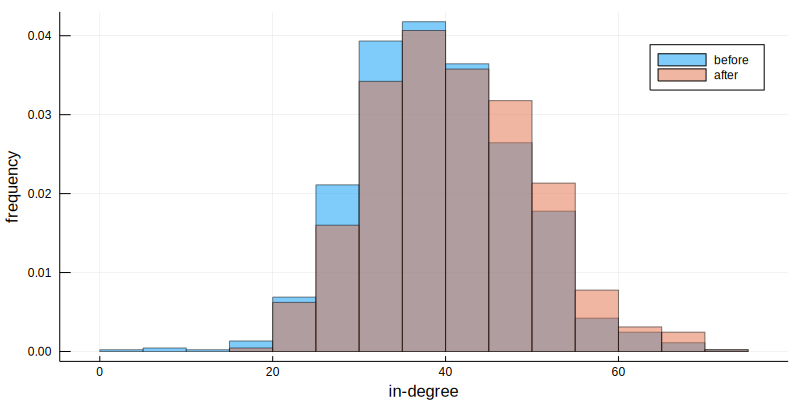

In [49]:
let p = histogram(hcat(indegree(Gᵦ), indegree(Gₐ)), labels=["before" "after"], xlabel="in-degree", ylabel="frequency", α=0.5, size=(800,400), normalize=true)
    savefig(p, joinpath(outdir, "indegree.svg"))
    p
end

In [50]:
ApproximateTwoSampleKSTest(indegree(Gᵦ), indegree(Gₐ))

┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests /home/ec2-user/.julia/packages/HypothesisTests/M3Ysg/src/kolmogorov_smirnov.jl:167


Approximate two sample Kolmogorov-Smirnov test
----------------------------------------------
Population details:
    parameter of interest:   Supremum of CDF differences
    value under h_0:         0.0
    point estimate:          0.13111111111111112

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           <1e-6

Details:
    number of observations:   [900,900]
    KS-statistic:              2.781286672667087


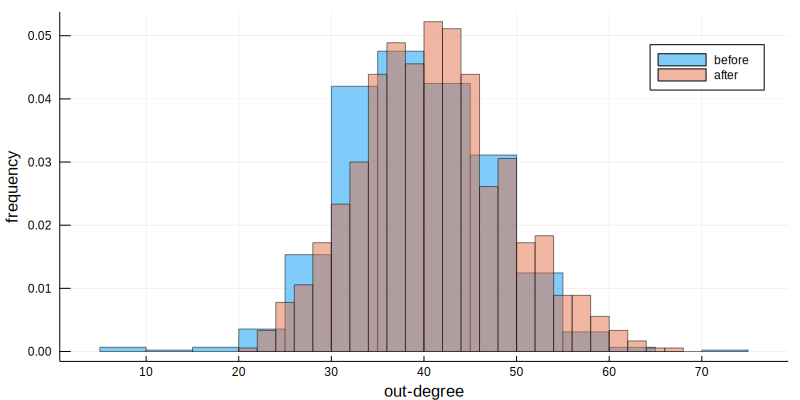

In [51]:
let p = histogram(hcat(outdegree(Gᵦ), outdegree(Gₐ)), labels=["before" "after"], xlabel="out-degree", ylabel="frequency", α=0.5, size=(800,400), normalize=true)
    savefig(p, joinpath(outdir, "outdegree.svg"))
    p
end

In [52]:
ApproximateTwoSampleKSTest(indegree(Gnetᵦ), indegree(Gnetₐ))

┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests /home/ec2-user/.julia/packages/HypothesisTests/M3Ysg/src/kolmogorov_smirnov.jl:167


Approximate two sample Kolmogorov-Smirnov test
----------------------------------------------
Population details:
    parameter of interest:   Supremum of CDF differences
    value under h_0:         0.0
    point estimate:          0.10888888888888887

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           <1e-4

Details:
    number of observations:   [900,900]
    KS-statistic:              2.309882151876055


In [53]:
function grid_layout(g::AbstractGraph)
    w = Int(sqrt(nv(g)))
    x_pos, y_pos = Real[], Real[]
    for i in 1:nv(g)
        x = (i - 1) ÷ w
        y = (i - 1) % w
        push!(x_pos, x)
        push!(y_pos, y)
    end
    x_pos, y_pos
end

grid_layout (generic function with 1 method)

In [54]:
rescale(xs::AbstractArray) = let (min, max) = extrema(xs)
    (xs .- min) / (max - min)
end

rescale (generic function with 2 methods)

In [29]:
function prettygraph(g; outgoing=true, showedges=true)
    ws = if outgoing
        weights(g)
    else
        transpose(weights(g))
    end
    wscaled = rescale(ws)
    G = SimpleDiGraph(ws)

    if showedges
        edgewidth = [wscaled[e.src,e.dst] for e in edges(G)]
        edgestroke = RGBA.(1.0, 1.0, 1.0, edgewidth)
    else
        edgestroke = RGBA(1.0, 1.0, 1.0, 0.0)
        edgewidth = 0.0
    end
    
    teϕ = rescale([sum(ws[i, neighbors(G, i)]) for i in 1:nv(G)])
    nodesize = teϕ ./ degree(G)
    nodecolor = RGB.(teϕ, 0.0, 0.0)
    
    gplot(G, layout=grid_layout, nodesize=nodesize, nodefillc=nodecolor, edgestrokec=edgestroke, arrowlengthfrac=0.01, edgelinewidth=edgewidth)
end

prettygraph (generic function with 1 method)

In [30]:
draw(PNG(joinpath(outdir, "before-outgoing.png"), 39cm, 39cm), prettygraph(Gᵦ))
draw(PNG(joinpath(outdir, "before-outgoing-no-edges.png"), 39cm, 39cm), prettygraph(Gᵦ; showedges=false))
draw(PNG(joinpath(outdir, "before-incoming.png"), 39cm, 39cm), prettygraph(Gᵦ; outgoing=false))
draw(PNG(joinpath(outdir, "before-incoming-no-edges.png"), 39cm, 39cm), prettygraph(Gᵦ; outgoing=false, showedges=false))

In [31]:
draw(PNG(joinpath(outdir, "after-outgoing.png"), 39cm, 39cm), prettygraph(Gₐ))
draw(PNG(joinpath(outdir, "after-outgoing-no-edges.png"), 39cm, 39cm), prettygraph(Gₐ; showedges=false))
draw(PNG(joinpath(outdir, "after-incoming.png"), 39cm, 39cm), prettygraph(Gₐ; outgoing=false))
draw(PNG(joinpath(outdir, "after-incoming-no-edges.png"), 39cm, 39cm), prettygraph(Gₐ; outgoing=false, showedges=false))